# Camera Calibration.

Cameras are often distorted because of their lenses or sensors. It's helpful to be able to undistort your image in self driving applications so you can get an accurate representation of the world. Speficially it can be used to create a birds eye view of your path and it's needed to make visual odometry work.


This notebooks shows two different apporaches to undistort images. 
1. For standard cameras that only have minor distortions. 
2. For fisheye cameras with lots of distortion. 

In [6]:
import os
import glob

In [29]:
import pandas as pd
import numpy as np
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'

%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

## The setup
I'm using the standard donkey2 car that uses the wide angel Sain Smart Raspberry Pi camera. 

In [8]:
CHECKERBOARD_DIM = (7,9)

## The data
For both calibration methods you need a collection of images of a checkerboard. To get this with my donkey car, I changed the camera resolution to 640x480 and my drive loop hz to 3 then started it with the drive command and pointed it at a screen that was showing the checkerboard. After moving it around in many different angles I collected ~200 images that are saved in this folder...

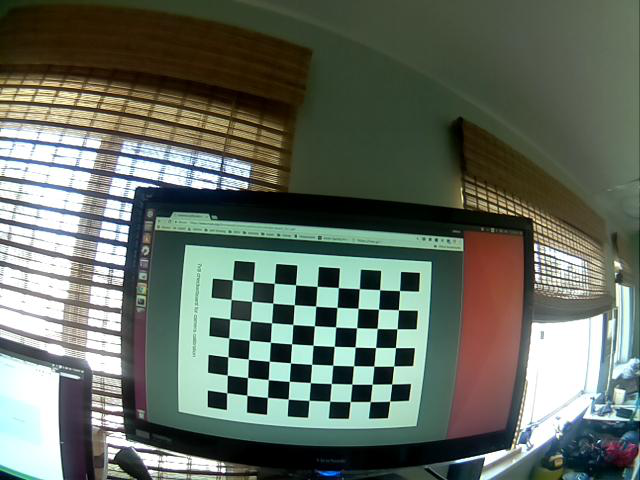

In [168]:
images_folder_path = './data/fisheye_camera_calibration/'
images = glob.glob(os.path.join(images_folder_path,'*.jpg'))
Image.open(os.path.join(images[0]))

### The usual method of clibrating a camera

This method is taken straight from the [OpenCV tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html) and can work well for cameras with minor distortions.

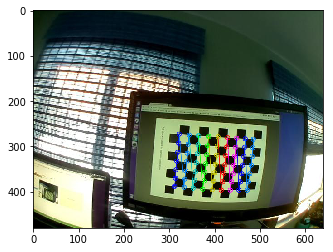

In [77]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((CHECKERBOARD_DIM[0]*CHECKERBOARD_DIM[1],3), np.float32)
objp[:,:2] = np.mgrid[0:CHECKERBOARD_DIM[0],0:CHECKERBOARD_DIM[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in images[0:50]:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD_DIM, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD_DIM, corners2,ret)
        
plt.imshow(img)


In [11]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                   gray.shape[::-1],None,None)


In [12]:
img = cv2.imread(images[2])
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

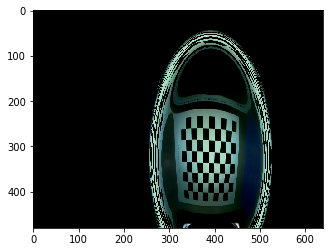

In [13]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
plt.imshow(dst)

Here we can see that this is not the result we want. So lets try the calibration method for the fisheye lense.

## The fisheye method of calibrating a camera. 

This code is mostly copied by Kenneth Jaing's [Medium post](https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0).

In [84]:
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW

In [85]:
objp = np.zeros((1, CHECKERBOARD_DIM[0]*CHECKERBOARD_DIM[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD_DIM[0], 0:CHECKERBOARD_DIM[1]].T.reshape(-1, 2)

In [86]:
images[97]

'./data/fisheye_camera_calibration/181_cam-image_array_.jpg'

In [87]:
images[176]

'./data/fisheye_camera_calibration/155_cam-image_array_.jpg'

In [173]:
import random

_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
    
#random.shuffle(images)

for fname in images[:]:

    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD_DIM, 
                                             cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
        
N_OK = len(objpoints)
print("Found " + str(N_OK) + " valid images for calibration")

Found 180 valid images for calibration


In [174]:
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

DIM=(640, 480)
K=np.array([[352.81976042437407, 0.0, 309.8835556149811], [0.0, 330.3883538892136, 241.68073502029995], [0.0, 0.0, 1.0]])
D=np.array([[-0.04651275799849617], [-0.00205612795823227], [-0.017685697995019633], [0.012977195205127278]])


In [175]:
def undistort(img_arr):
    h, w = img_arr.shape[:2]
    DIM = (w, h)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), 
                                                     K, DIM, cv2.CV_16SC2)

    undistorted_img = cv2.remap(img_arr, map1, map2, interpolation=cv2.INTER_LINEAR, 
                                borderMode=cv2.BORDER_CONSTANT)

    return undistorted_img



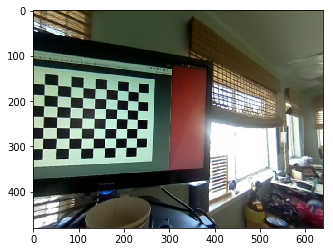

In [176]:
img = Image.open(images[60])
undistorted = undistort(np.array(img))
plt.imshow(undistorted)

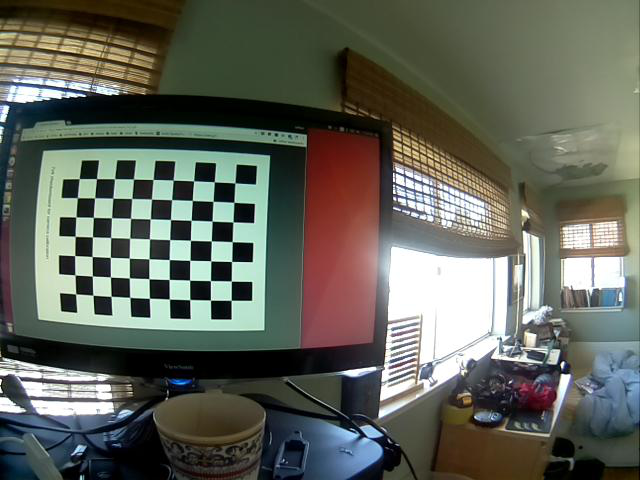

In [177]:

img